<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Project SDMA</h1>
</div>
<br>

## __Structure__

1. Data Retrieval

    1.1 Reddit Data

    1.2 LIWC Dictionaries (IVs)

2. Data Analysis 

    2.1 Negative Binomial Regression (H1, H2)

    2.2 Negative Binomial Regression with Interactions (H3)

3. Robustness Tests

    3.1 Negative Binomial vs. Poisson Regression (check for Overdispersion)

    3.2 Independence of Models (Bootstrapping)
    
    3.3 Full model without controls

    3.4 Model with only moral-emotional counts

4. Plots and Visualization

    4.1 Prediction of Submission Score (just Moral and Moral-Emotional) (4x4)

    4.2 Prediction of Submission Score (all word counts) (4x4)


In [ ]:
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

from fnmatch import fnmatch
from tqdm import tqdm
from statsmodels.discrete.discrete_model import NegativeBinomial
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2

## 1. Data Retrieval
### 1.1 Reddit Data

In [23]:
abortion_raw = pd.read_json("data/Abortiondebate_submissions", lines=True)
vaccines_raw= pd.read_json("data/CovidVaccinated_submissions", lines=True)
israel_raw= pd.read_json("data/IsraelPalestine_submissions", lines=True)
neutral_raw = pd.read_json("data/NeutralPolitics_submissions", lines=True)

In [24]:
datasets = {"abortion": abortion_raw,"vaccines": vaccines_raw,"israel": israel_raw,"neutral": neutral_raw}

for name,df in datasets.items():

    # Preprocessing
    df = df[~df["selftext"].str.strip().isin(["[removed]", "[deleted]", ""])]
    df = df[~df["selftext"].str.strip().str.startswith("[View Poll]")]
    df = df[~df["selftext"].str.strip().str.match(r'^https?://\S+$')]
    df = df[~df["selftext"].str.strip().str.match(r'^\d+$')]
    df = df[df["stickied"]==False]

    # Selection of relevant variables
    df = df[["author","title","selftext","num_comments","score"]]
    
    datasets[name] = df

In [12]:
abortion_df = datasets["abortion"]
vaccines_df = datasets["vaccines"]
israel_df = datasets["israel"]
neutral_df = datasets["neutral"]

### 1.2 LIWC Dictionaries

In [1]:
with open("data/emo_dict.txt", "r", encoding="utf-8") as f:
    emo_dict = f.read().replace("\n", "").split(",")
    emo_dict= [w.strip().strip('"') for w in emo_dict if w.strip()]

with open("data/moral_dict.txt", "r", encoding="utf-8") as f:
    moral_dict = f.read().replace("\n", "").split(",")
    moral_dict= [w.strip().strip('"') for w in moral_dict if w.strip()]

with open("data/moral_emo_dict.txt", "r", encoding="utf-8") as f:
    moral_emo_dict = f.read().replace("\n", "").split(",")
    moral_emo_dict= [w.strip().strip('"') for w in moral_emo_dict if w.strip()]

In [14]:
def tokenize(text):
    text = text.lower().replace(".","").replace("!","").replace("?","").replace(":","").replace(",","").split()
    return text

In [15]:
def count_dict_tokens(tokens,dict):
    count = 0
    for token in tokens:
        for word in dict:
            if fnmatch(token,word):
                count += 1
                break
    return count

In [ ]:
for name,df in datasets.items():
    df["tokens"] = df["selftext"].apply(tokenize)
    
    emo_counts = []
    moral_counts = []
    moral_emo_counts = []

    for tokens in tqdm(df["tokens"],desc=f"Processing {name}"):
        count_emo = count_dict_tokens(tokens, emo_dict)
        count_moral = count_dict_tokens(tokens, moral_dict)
        count_moral_emo = count_dict_tokens(tokens, moral_emo_dict)

        emo_counts.append(count_emo)
        moral_counts.append(count_moral)
        moral_emo_counts.append(count_moral_emo)

    df["emo_count"] = emo_counts
    df["moral_count"] = moral_counts
    df["moral_emo_count"] = moral_emo_counts

    datasets[name] = df

Processing neutral: 100%|██████████| 4886/4886 [20:51<00:00,  3.90it/s] 


In [ ]:
#abortion_df.to_csv("data/abortion.csv")
#vaccines_df.to_csv("data/vaccines.csv")
#israel_df.to_csv("data/israel.csv")
#neutral_df.to_csv("data/neutral.csv")

## 2. Data Analysis
### 2.1 Negative Binomial Regression (H1, H2)

In [25]:
abortion_df = pd.read_csv("data/abortion.csv",index_col=0)
vaccines_df = pd.read_csv("data/vaccines.csv",index_col=0)
israel_df = pd.read_csv("data/israel.csv",index_col=0)
neutral_df = pd.read_csv("data/neutral.csv",index_col=0)

datasets = {"abortion": abortion_df,"vaccines": vaccines_df,"israel": israel_df,"neutral": neutral_df}

In [26]:
# Control Variable (Length of Submission)
for name,df in datasets.items():
    df["submission_length"] = df["tokens"].apply(len)
    datasets[name] = df

In [ ]:
# Estimation
results = []

for name, df in datasets.items():
    df = df[df["submission_length"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["emo_count", "moral_count", "moral_emo_count", "submission_length"]])
    X = sm.add_constant(x)

    model = NegativeBinomial(y, X)
    result = model.fit(disp=0)

    param_names = ["const", "emo_count", "moral_count", "moral_emo_count", "submission_length"]
    parameter = dict(zip(param_names, result.params))
    bse = dict(zip(param_names, result.bse))
    pvals = dict(zip(param_names, result.pvalues))
    irr = dict(zip(param_names, np.exp(result.params)))

    results.append({
        "dataset": name,
        "logLik": result.llf,
        "params": parameter,
        "IRR": irr,
        "std_errors": bse,
        "p_values": pvals})

In [ ]:
# Creation of Latex Output
table_rows = []
for res in results:
    row = {"Dataset": res["dataset"]}

    for var in ["emo_count", "moral_count", "moral_emo_count", "submission_length", "const"]:
        irr = res["IRR"].get(var)
        se = res["std_errors"].get(var)
        p = res["p_values"].get(var)

        sig = "*" if p < 0.05 else ""
        row[var] = f"{irr:.2f}{sig}\n({se:.2f})"

    table_rows.append(row)

results_df = pd.DataFrame(table_rows)
results_df = results_df.set_index("Dataset").T

latex_code = results_df.to_latex(column_format="l" + "c" * len(results_df.columns))

#print(latex_code)

### 2.2 Negative Binomial Regression with Interactions (H3)

In [ ]:
# Estimation
warnings.filterwarnings("ignore")
df_h3 = pd.DataFrame()

for name, df in datasets.items():
    df_copy = df.copy()
    df_copy["subreddit"] = name
    df_h3 = pd.concat([df_h3, df_copy], ignore_index=True)

 # the optimization terminates at N=9500 with identical results, so I decided to just leave itr 
 # at 10k and surpress the warnings
df_h3 = df_h3[df_h3["submission_length"] <= 10000].copy()

df_h3["subreddit"] = pd.Categorical(df_h3["subreddit"],
    categories=["neutral", "abortion", "vaccines", "israel"],
    ordered=True) # I wanted to have r/NeutralPolitics as my base group
df_h3 = pd.get_dummies(df_h3, columns=["subreddit"], drop_first=True)
for col in df_h3.columns:
    if col.startswith("subreddit_"):
        df_h3[col] = df_h3[col].astype(int)


scaler = StandardScaler()
predictor_cols = ["emo_count", "moral_count", "moral_emo_count", "submission_length"]
df_h3[predictor_cols] = scaler.fit_transform(df_h3[predictor_cols])

interaction_terms = []
for subreddit_col in df_h3.columns:
    if subreddit_col.startswith("subreddit_"):
        interaction_name = f"moral_emo_x_{subreddit_col}"
        df_h3[interaction_name] = df_h3["moral_emo_count"] * df_h3[subreddit_col]
        interaction_terms.append(interaction_name)


x_cols = predictor_cols + [col for col in df_h3.columns if col.startswith("subreddit_")] + interaction_terms
X = sm.add_constant(df_h3[x_cols])
y = df_h3["score"]

model = NegativeBinomial(y, X)
result = model.fit(disp=0)

irr = np.exp(result.params)

In [ ]:
# Creation of Latex Output
for var in param_names:
    coef = result.params[var]
    se = result.bse[var]
    z = coef / se
    p = result.pvalues[var]
    irr = np.exp(coef)
    ci_low = np.exp(coef - 1.96 * se)
    ci_high = np.exp(coef + 1.96 * se)
    sig = "*" if p < 0.05 else ""

    row = {
        "Variable": var,
        "IRR (SE)": f"{irr:.2f}{sig}\n({se:.2f})",
        "z": f"{z:.2f}",
        "95% CI": f"[{ci_low:.2f}, {ci_high:.2f}]"
    }
    table_rows.append(row)

results_df = pd.DataFrame(table_rows).set_index("Variable")

latex_code = results_df.to_latex(column_format="l c c c", escape=False)
#print(latex_code)

## 3. Robustness Tests

### 3.1 Negative Binomial vs. Poisson Regression (check for Overdispersion)

In [7]:
for name, df in datasets.items():
    df = df[df["submission_length"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["emo_count", "moral_count", "moral_emo_count", "submission_length"]])
    X = sm.add_constant(x)

    # Negative Binomial Model
    model_nb = NegativeBinomial(y, X)
    result_nb = model_nb.fit(disp=0)
    ll_nb = result_nb.llf

    # Poisson Model 
    model_pois = sm.GLM(y, X, family=sm.families.Poisson())
    result_pois = model_pois.fit()
    ll_pois = result_pois.llf

    # Likelihood Ratio Test
    LR = 2 * (ll_nb - ll_pois)
    p_value = chi2.sf(LR, df = 1)

    print(f"""LR-Test statistic between NB-Model and Poisson Model for the dataset '{name.capitalize()}' is {LR:.2f}.
          Compared to a Chi-squared distribution with degree of freedom 1 the following p-value results: {p_value:.4f}\n""")

LR-Test statistic between NB-Model and Poisson Model for the dataset 'Abortion' is 86900.94.
          Compared to a Chi-squared distribution with degree of freedom 1 the following p-value results: 0.0000

LR-Test statistic between NB-Model and Poisson Model for the dataset 'Vaccines' is 371477.92.
          Compared to a Chi-squared distribution with degree of freedom 1 the following p-value results: 0.0000

LR-Test statistic between NB-Model and Poisson Model for the dataset 'Israel' is 189575.63.
          Compared to a Chi-squared distribution with degree of freedom 1 the following p-value results: 0.0000

LR-Test statistic between NB-Model and Poisson Model for the dataset 'Neutral' is 1319061.15.
          Compared to a Chi-squared distribution with degree of freedom 1 the following p-value results: 0.0000



p-value < 0.05 suggests overdispersion in the data. In this case a Negative-Binomial Model outperforms a Poisson Model signficantly.
As all four datasets seems to show significant signs of overdispersion, the use of a NB-Model over a Poisson Model is valid.

#### 3.2 Independence of Models (Bootstrapping)

In [ ]:
np.random.seed(1)
coef_dict = {}

for name, df in datasets.items():
    sample_df = df[df["submission_length"] <= 10000].copy()

    user_counts = sample_df["author"].value_counts()
    multi_submission_users = user_counts[user_counts > 1].index
    sample_df = sample_df[sample_df["author"].isin(multi_submission_users)].copy()

    coef_dict[name] = {key: [] for key in ["emo_count", "moral_count", "moral_emo_count"]}

    for i in range(1,10001):
        sample = sample_df.sample(1000,replace=True)
        
        y = sample["score"].values
        scaler = StandardScaler()
        x = scaler.fit_transform(sample[["emo_count", "moral_count", "moral_emo_count", "submission_length"]])
        X = sm.add_constant(x)

        model = NegativeBinomial(y, X)
        result = model.fit(disp=0)
        param_names = ["emo_count", "moral_count", "moral_emo_count"]
        columns = ["const"] + param_names + ["submission_length"]
        params_named = dict(zip(columns, result.params))
        for param in param_names:
            coef_dict[name][param].append(params_named[param])

with open("data/bootstrap_data.json", "w") as f:
    json.dump(coef_dict, f)

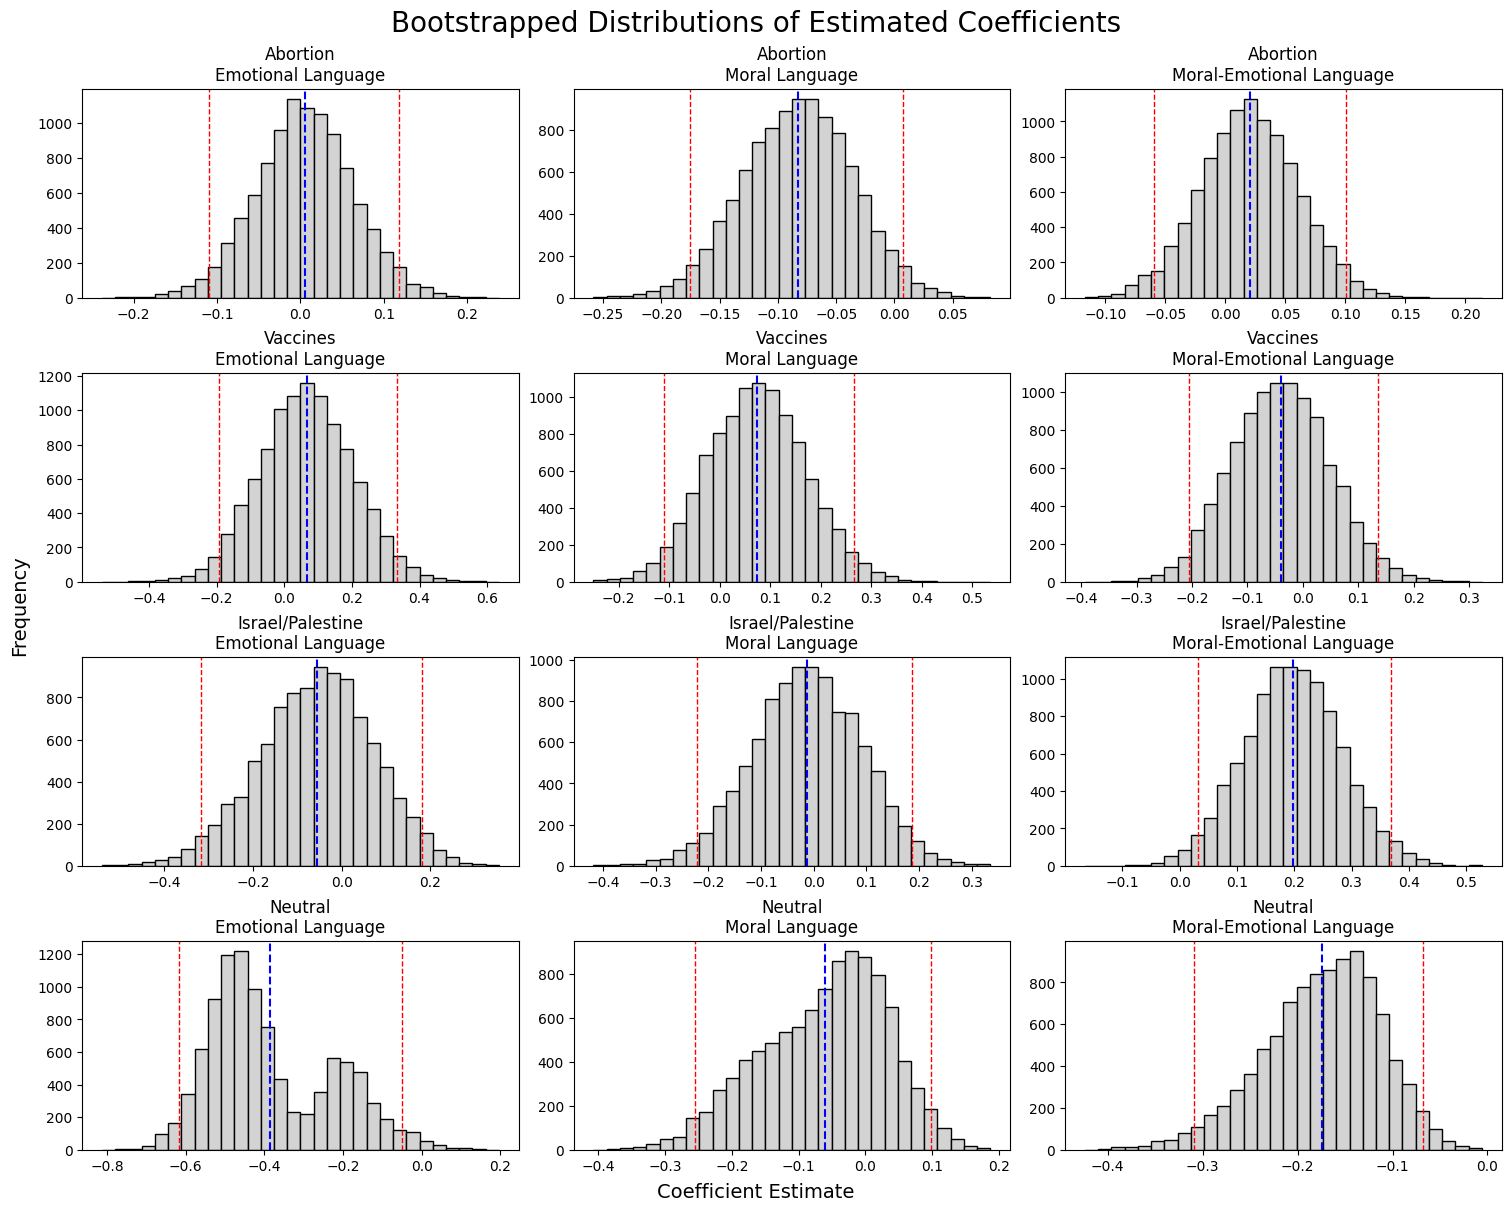

In [28]:
bootstrap_data = pd.read_json("data/bootstrap_data.json")

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12), constrained_layout=True)

df_names = ["abortion", "vaccines", "israel", "neutral"]
predictors = ["emo_count", "moral_count", "moral_emo_count"]
predictor_labels = ["Emotional Language", "Moral Language", "Moral-Emotional Language"]
dataset_labels = ["Abortion", "Vaccines", "Israel/Palestine", "Neutral"]

for index, dataset in enumerate(df_names):
    for jndex, predictor in enumerate(predictors):
        ax = axes[index, jndex]
        coefs = bootstrap_data[dataset][predictor]
        ax.hist(coefs, bins=30, color='lightgrey', edgecolor='black')

        mean = np.mean(coefs)
        lower = np.percentile(coefs, 2.5)
        upper = np.percentile(coefs, 97.5)

        ax.axvline(mean, color='blue', linestyle='--', linewidth=1.5)
        ax.axvline(lower, color='red', linestyle='--', linewidth=1)
        ax.axvline(upper, color='red', linestyle='--', linewidth=1)

        ax.set_title(f"{dataset_labels[index]}\n{predictor_labels[jndex]}", fontsize=12)

plt.suptitle("Bootstrapped Distributions of Estimated Coefficients", fontsize=20)
fig.supxlabel("Coefficient Estimate", fontsize=14)
fig.supylabel("Frequency", fontsize=14)
plt.show()


### 3.3 Full model without controls

In [ ]:
# Without Control
results = []

for name, df in datasets.items():
    df = df[df["submission_length"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["emo_count", "moral_count", "moral_emo_count"]])
    X = sm.add_constant(x)

    model = NegativeBinomial(y, X)
    result = model.fit(disp=0)

    param_names = ["const", "emo_count", "moral_count", "moral_emo_count", "submission_length"]
    parameter = dict(zip(param_names, result.params))
    bse = dict(zip(param_names, result.bse))
    pvals = dict(zip(param_names, result.pvalues))
    irr = dict(zip(param_names, np.exp(result.params)))

    results.append({
        "dataset": name,
        "logLik": result.llf,
        "params": parameter,
        "IRR": irr,
        "std_errors": bse,
        "p_values": pvals})
    
table_rows = []
for res in results:
    row = {"Dataset": res["dataset"]}

    for var in ["emo_count", "moral_count", "moral_emo_count", "const"]:
        irr = res["IRR"].get(var)
        se = res["std_errors"].get(var)
        p = res["p_values"].get(var)

        sig = "*" if p < 0.05 else ""
        row[var] = f"{irr:.2f}{sig}\n({se:.2f})"

    table_rows.append(row)

results_df = pd.DataFrame(table_rows)
results_df = results_df.set_index("Dataset").T

latex_code = results_df.to_latex(column_format="l" + "c" * len(results_df.columns))

#print(latex_code)

### 3.4 Model with only moral-emotional counts

In [ ]:
# Just moral-emotional
results = []

for name, df in datasets.items():
    df = df[df["submission_length"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["moral_emo_count"]])
    X = sm.add_constant(x)

    model = NegativeBinomial(y, X)
    result = model.fit(disp=0)

    param_names = ["const","moral_emo_count"]
    parameter = dict(zip(param_names, result.params))
    bse = dict(zip(param_names, result.bse))
    pvals = dict(zip(param_names, result.pvalues))
    irr = dict(zip(param_names, np.exp(result.params)))

    results.append({
        "dataset": name,
        "logLik": result.llf,
        "params": parameter,
        "IRR": irr,
        "std_errors": bse,
        "p_values": pvals})
    
table_rows = []
for res in results:
    row = {"Dataset": res["dataset"]}

    for var in ["moral_emo_count", "const"]:
        irr = res["IRR"].get(var)
        se = res["std_errors"].get(var)
        p = res["p_values"].get(var)

        sig = "*" if p < 0.05 else ""
        row[var] = f"{irr:.2f}{sig}\n({se:.2f})"

    table_rows.append(row)

results_df = pd.DataFrame(table_rows)
results_df = results_df.set_index("Dataset").T

latex_code = results_df.to_latex(column_format="l" + "c" * len(results_df.columns))

#print(latex_code)

## 4. Plots and Visualization
### 4.1 Prediction of Submission Score (just Moral and Moral-Emotional) (4x4)

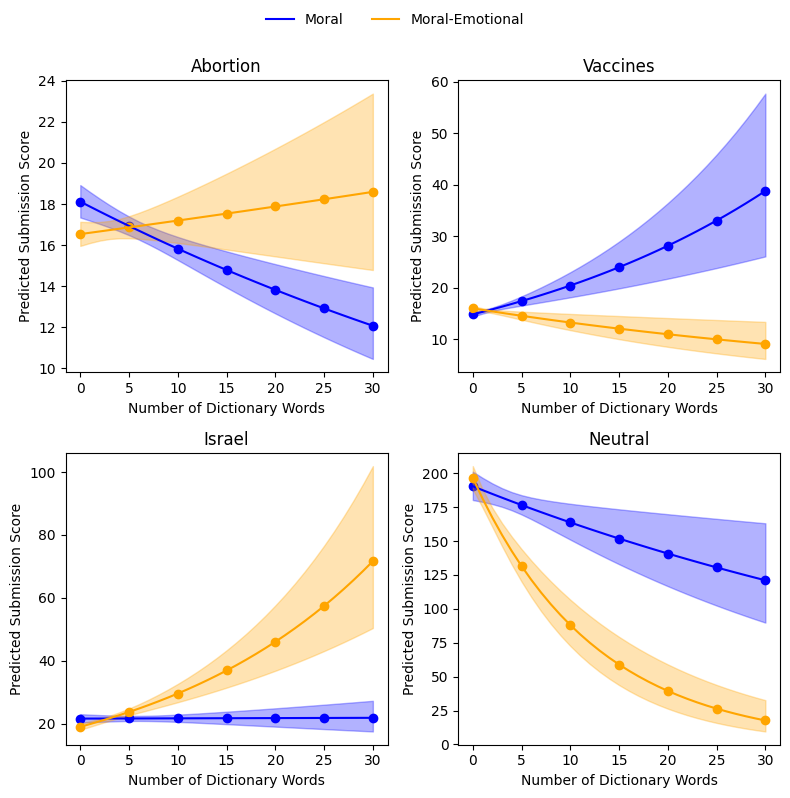

In [29]:
warnings.filterwarnings("ignore", message="using default log-link in get_prediction") # it's not a bad warning but the messages annoyed me terribly

fig, axes = plt.subplots(2, 2, figsize=(8, 8)) 
axes = axes.flatten()
for ax, (name, df) in zip(axes, datasets.items()):
    df = df[df["submission_length"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["emo_count", "moral_count", "moral_emo_count", "submission_length"]])
    X = sm.add_constant(x)

    model = NegativeBinomial(y, X).fit(disp=0)

    mean_vals = df[["emo_count", "moral_count", "moral_emo_count", "submission_length"]].mean()

    moral_range = np.arange(0, 31)
    moral_emo_range = np.arange(0, 31)

    df_pred = pd.DataFrame({
        "emo_count": mean_vals["emo_count"],
        "moral_count": moral_range,
        "moral_emo_count": mean_vals["moral_emo_count"],
        "submission_length": mean_vals["submission_length"]})
    df_pred_moemo = pd.DataFrame({
        "emo_count": mean_vals["emo_count"],
        "moral_count": mean_vals["moral_count"],
        "moral_emo_count": moral_emo_range,
        "submission_length": mean_vals["submission_length"]})

    X_pred_scaled = scaler.transform(df_pred)
    X_pred = sm.add_constant(X_pred_scaled)
    X_pred_emo_scaled = scaler.transform(df_pred_moemo)
    X_pred_emo = sm.add_constant(X_pred_emo_scaled)

    pred = model.get_prediction(X_pred, transform=True).summary_frame()
    pred_emo = model.get_prediction(X_pred_emo, transform=True).summary_frame()

    ax.plot(moral_range, pred["predicted"], label="Moral", color="blue")
    ax.fill_between(moral_range, pred["ci_lower"], pred["ci_upper"], color="blue", alpha=0.3)
    indices = np.arange(0, len(moral_range), 5)
    ax.scatter(moral_range[indices], pred["predicted"].iloc[indices], color="blue")

    ax.plot(moral_emo_range, pred_emo["predicted"], label="Moral-Emotional", color="orange")
    ax.fill_between(moral_emo_range, pred_emo["ci_lower"], pred_emo["ci_upper"], color="orange", alpha=0.3)
    indices = np.arange(0, len(moral_emo_range), 5)
    ax.scatter(moral_emo_range[indices], pred_emo["predicted"].iloc[indices], color="orange")

    ax.set_xlabel("Number of Dictionary Words")
    ax.set_ylabel("Predicted Submission Score")
    ax.set_title(name.capitalize())

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### 4.2 Prediction of Submission Score (all word counts) (4x4)

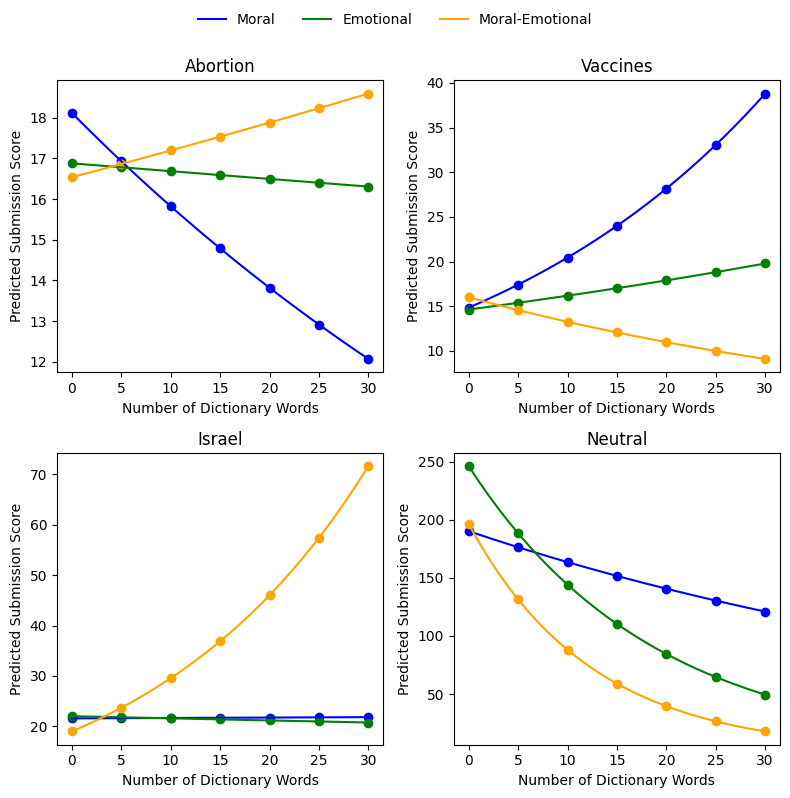

In [30]:
warnings.filterwarnings("ignore", message="using default log-link in get_prediction") # it's not a bad warning but the messages annoyed me terribly

fig, axes = plt.subplots(2, 2, figsize=(8, 8)) 
axes = axes.flatten()
for ax, (name, df) in zip(axes, datasets.items()):
    df = df[df["submission_length"] <= 10000].copy()
    y = df["score"].values

    scaler = StandardScaler()
    x = scaler.fit_transform(df[["emo_count", "moral_count", "moral_emo_count", "submission_length"]])
    X = sm.add_constant(x)

    model = NegativeBinomial(y, X).fit(disp=0)

    mean_vals = df[["emo_count", "moral_count", "moral_emo_count", "submission_length"]].mean()

    moral_range = np.arange(0, 31)
    emo_range = np.arange(0,31)
    moral_emo_range = np.arange(0, 31)

    df_pred = pd.DataFrame({
        "emo_count": mean_vals["emo_count"],
        "moral_count": moral_range,
        "moral_emo_count": mean_vals["moral_emo_count"],
        "submission_length": mean_vals["submission_length"]})
    df_pred_emo = pd.DataFrame({
        "emo_count": emo_range,
        "moral_count": mean_vals["moral_count"],
        "moral_emo_count": mean_vals["moral_emo_count"],
        "submission_length": mean_vals["submission_length"]})
    df_pred_moemo = pd.DataFrame({
        "emo_count": mean_vals["emo_count"],
        "moral_count": mean_vals["moral_count"],
        "moral_emo_count": moral_emo_range,
        "submission_length": mean_vals["submission_length"]})

    X_pred_scaled = scaler.transform(df_pred)
    X_pred = sm.add_constant(X_pred_scaled)
    X_pred_emo_scaled = scaler.transform(df_pred_emo)
    X_pred_emo = sm.add_constant(X_pred_emo_scaled)
    X_pred_moemo_scaled = scaler.transform(df_pred_moemo)
    X_pred_moemo = sm.add_constant(X_pred_moemo_scaled)

    pred = model.get_prediction(X_pred, transform=True).summary_frame()
    pred_emo = model.get_prediction(X_pred_emo, transform=True).summary_frame()
    pred_moemo = model.get_prediction(X_pred_moemo, transform=True).summary_frame()

    ax.plot(moral_range, pred["predicted"], label="Moral", color="blue")
    #ax.fill_between(moral_range, pred["ci_lower"], pred["ci_upper"], color="blue", alpha=0.3)
    indices = np.arange(0, len(moral_range), 5)
    ax.scatter(moral_range[indices], pred["predicted"].iloc[indices], color="blue")

    ax.plot(emo_range, pred_emo["predicted"], label="Emotional", color="green")
    #ax.fill_between(emo_range, pred["ci_lower"], pred["ci_upper"], color="green", alpha=0.3)
    indices = np.arange(0, len(emo_range), 5)
    ax.scatter(emo_range[indices], pred_emo["predicted"].iloc[indices], color="green")

    ax.plot(moral_emo_range, pred_moemo["predicted"], label="Moral-Emotional", color="orange")
    #ax.fill_between(moral_emo_range, pred_emo["ci_lower"], pred_emo["ci_upper"], color="orange", alpha=0.3)
    indices = np.arange(0, len(moral_emo_range), 5)
    ax.scatter(moral_emo_range[indices], pred_moemo["predicted"].iloc[indices], color="orange")

    ax.set_xlabel("Number of Dictionary Words")
    ax.set_ylabel("Predicted Submission Score")
    ax.set_title(name.capitalize())

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
